<div style="background-image:url(instaseis_images/bertinoro.jpg); padding: 10px 30px 20px 30px; background-size:cover; background-opacity:50%; border-radius:5px">
<p style="float:right; margin-top:20px; padding: 20px 60px 0px 10px; background:rgba(255,255,255,0.75); border-radius:10px;">
<img width="400px" src=instaseis_images/logo.png>
</p>

<h1 style="color:#333">First TIDES Training School</h1>
<h5 style="color:#FFF">Bertinoro (FC), Italy, June 1-5 2015</h5>

<h2 style="color:#EEE">Day 4: Instaseis Tutorial</h2>

<h3 style="color:#FFF">Martin van Driel and Lion Krischer</h3>
</div>

**Goal of the Practical:** To be able to calculate seismograms on a 1D background model with [Instaseis](http://www.instaseis.net), assuming the Green's function database computed with [AxiSEM](http://www.axisem.info) is provided.


**Tentative Timetable:**

* [10 min] Introduction and getting everyone on the same page
* [10 min] Instaseis GUI
* [40 min] Python API intro and basic exercise (everybody should do this): use Instaseis to compute seismograms for the same earthquakes and stations as the last days.
* [30 - x min] Advanced exercises: some fun stuff to choose from

**Basic Tasks:**

* Play with GUI: mechanism, depth, location, arrival times...
* Calculate synthetics for the given events and stations

**Advanced Tasks (choose one):**

* Plot record section
* Finite Source, compare to point source solution
* Automatic discrimation between meteorite impacts and quakes

## Exercise 1: Play around with the GUI

The GUI is great tool to teach and observe basic properties of seismograms. Launch it by entering

```bash
$ python -m instaseis.gui
```

in a shell.

<img style="width:60%" src="instaseis_images/GUI_screenshot.png"></img>


#### Tasks:

1. Modify the source depth for a source at teleseismic distance; observe how surface waves behave.
2. Observe how the polarity of the first arrivals flips when crossing nodal planes of a double couple source.
3. Observe triplicated phases for shallow sources (probably impossible with 20s database)
4. Observe the Hilbert transformed shape of reflected phases.

-----

Basic lines to set up the notebook and some paths.

In [1]:
%pylab inline
from __future__ import print_function
import matplotlib.pylab as plt
import os
import obspy
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

event_folder = os.path.join("data", "events")
stations_folder = os.path.join("data", "stations")
quakeml_folder = os.path.join(event_folder, "quakeml")
cmtsolutions_folder = os.path.join(event_folder, "cmtsolutions")
finite_source_folder = os.path.join(event_folder, "finite_source")

Populating the interactive namespace from numpy and matplotlib


-----

## Basic Instaseis API Introduction

Please also have a look at our webpage - http://www.instaseis.net/ - where everything is documented extensively.

### Opening a Database

Before you can get going you have to (as always in Python) import `instaseis`.

In [2]:
import instaseis

An Instaseis database must be opened before it can be used. Please keep in mind that this is by far the most expensive operation in Instaseis so you want to limit how often you do it. There are a couple of optional parameters here, for now the defaults are fine.

The virtual box has a database at

**/home/tides/Desktop/data/instaseis_db**

In [3]:
db = instaseis.open_db("/home/tides/Desktop/data/instaseis_db")

Some basic information about the loaded database can be reviewed by just printing it.

In [4]:
print(db)

InstaseisDB reciprocal Green's function Database (v7) generated with these parameters:
	components           : vertical and horizontal
	velocity model       : ak135f
	attenuation          : True
	dominant period      : 20.000 s
	dump type            : displ_only
	excitation type      : dipole
	time step            : 4.997 s
	sampling rate        : 0.200 Hz
	number of samples    : 721
	seismogram length    : 3598.1 s
	source time function : gauss_0
	source shift         : 34.982 s
	spatial order        : 4
	min/max radius       : 6221.0 - 6371.0 km
	Planet radius        : 6371.0 km
	min/max distance     : 0.0 - 180.0 deg
	time stepping scheme : newmark2
	compiler/user        : gfortran 4.8.2 by vandriel on D-14-L-12
	directory/url        : ../../../Desktop/data/instaseis_db
	size of netCDF files : 914.9 MB
	generated by AxiSEM version v1.2-2-g9c86 at 2015-05-07T14:45:41.000000Z



From this you can already glance a couple of aspects of the database used for this tutorial:

* uses ak135f as its 1D model
* is accurate for periods down to 20 seconds
* includes vertical and horizontal components
* sources can have depths ranging from 0 to 150 km
* one hour long seismograms

### Receivers and Sources

Instaseis calculates seismograms for any source and receiver pair. A receiver has coordinates and optionally network and station codes. Using a reciprocal database, all receivers are assumed to be at the same depth, i.e. usually at the Earth surface.

In [5]:
rec = instaseis.Receiver(latitude=44.06238, longitude=10.59698,
                         network="IV", station="BDI")
print(rec)

Instaseis Receiver:
	longitude :   10.6 deg
	latitude  :   44.1 deg
	network   : IV
	station   : BDI



Sources are naturally a bit more complex and Instaseis offers a variety of ways to define them. A straightforward way for earthquakes is to pass coordinates, moment as well as strike, dip and rake.

In [6]:
src = instaseis.Source.from_strike_dip_rake(
    latitude=27.77, longitude=85.37, depth_in_m=12000.0,
    M0=1e+21, strike=32., dip=62., rake=90.)
print(src)

Instaseis Source:
	origin time      : 1970-01-01T00:00:00.000000Z
	Longitude        :   85.4 deg
	Latitude         :   27.8 deg
	Depth            : 1.2e+01 km
	Moment Magnitude :   8.00
	Scalar Moment    :   1.00e+21 Nm
	Mrr              :   8.29e+20 Nm
	Mtt              :  -2.33e+20 Nm
	Mpp              :  -5.96e+20 Nm
	Mrt              :   2.96e+20 Nm
	Mrp              :   4.74e+20 Nm
	Mtp              :  -3.73e+20 Nm



**Sidenode:** The moment tensor can be visualized using the Beachball function from obspy.imaging:

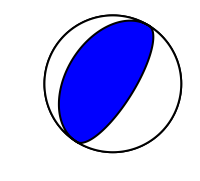

In [7]:
from obspy.imaging.beachball import Beachball

mt = src.tensor / src.M0 # normalize the tensor to avoid problems in the plotting
Beachball(mt, size=200, linewidth=2, facecolor='b');

Now we are ready to extract synthetic seismograms from the database:

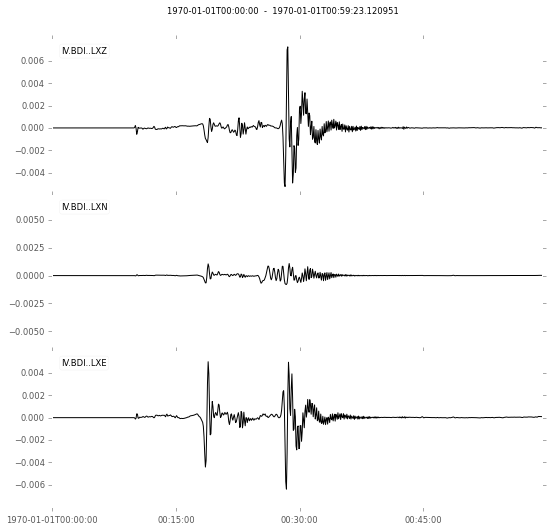

In [8]:
st = db.get_seismograms(source=src, receiver=rec)
st.plot();

**Done** This is all you need for a basic usage of Instaseis!

## Basic Exercise

**Task:** Calculate three component synthetics for the stations and events used on Monday and today and save them on disc in an organized manner so that you can work with them tomorrow.

#### Notes

1. Receiver objects can also be created from StationXML, SEED, or STATIONS files as well as obpy inventories using `instaseis.Receiver.parse()`; see the [documentation](http://www.instaseis.net/source.html#receiver) for details.
2. Source objects can also be created from QuakeML, CMTSOLUTIONS, and in other ways using `instaseis.Source.parse()`; see the [documentation](http://www.instaseis.net/source.html#source) for details.
3. The `get_seismograms()` method has a couple of extra arguments:
  * `kind`: `displacement`, `velocity`, `acceleration`
  * `remove_source_shift`, `reconvolve_stf`, `dt`,
  
  ... see the [documentation](http://www.instaseis.net/instaseis.html#instaseis.base_instaseis_db.BaseInstaseisDB.get_seismograms) for details.
4. You can use the properties of the Receiver and Source objects to create usefull filenames.

### 1. Load Receivers

**reminder:** you can use ObsPy to load stations and plot a map:

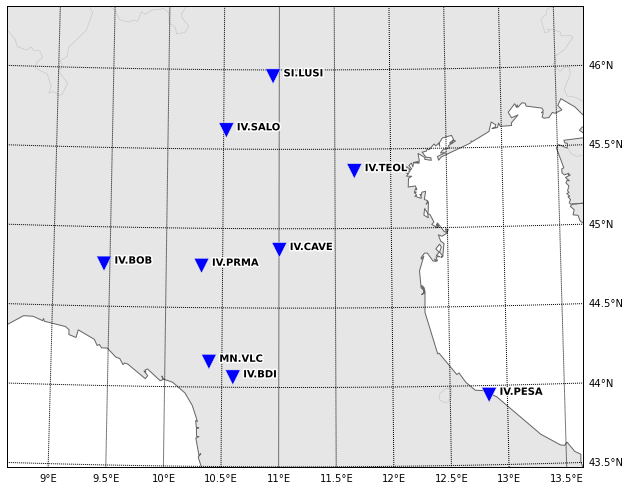

In [9]:
from obspy import read_inventory

station_filename = os.path.join(stations_folder, "all_stations.xml")

inventory = read_inventory(station_filename)
inventory.plot(projection="local", resolution="i");

This inventory can directly be used as input to generate `instaseis.Receiver` objects:

In [10]:
receivers = instaseis.Receiver.parse(inventory)
for rec in receivers[:2]:
    print(rec)

Instaseis Receiver:
	longitude :   10.6 deg
	latitude  :   44.1 deg
	network   : IV
	station   : BDI

Instaseis Receiver:
	longitude :    9.4 deg
	latitude  :   44.8 deg
	network   : IV
	station   : BOB



**Alternatively**, instaseis can directly open the station xml or STATIONS file (but then you don't have the nice plot):

In [11]:
receivers = instaseis.Receiver.parse(os.path.join(stations_folder, "all_stations.xml"))
print(receivers[0])
receivers = instaseis.Receiver.parse(os.path.join(stations_folder, "STATIONS"))
print(receivers[0])

Instaseis Receiver:
	longitude :   10.6 deg
	latitude  :   44.1 deg
	network   : IV
	station   : BDI

Instaseis Receiver:
	longitude :   10.6 deg
	latitude  :   44.1 deg
	network   : IV
	station   : BDI



### 2. Load Events
**reminder:** use ObsPy to load events from a QuakeML file containing all events and plot a map:

6 Event(s) in Catalog:
2015-04-25T06:11:58.400000Z | +27.770,  +85.370 | 7.9 Mwc
2014-04-04T01:37:57.900000Z | -20.610,  -70.910 | 6.2 Mwc
2015-05-12T07:05:28.500000Z | +27.560,  +86.100 | 7.2 Mwc
2014-04-01T23:47:31.500000Z | -19.700,  -70.810 | 8.1 Mwc
2012-05-29T07:00:02.880000Z | +44.842,  +11.066 | 5.6 Mw | manual
2015-01-23T06:51:20.340000Z | +44.127,  +11.121 | 4.3 Mw | manual
Instaseis Source:
	origin time      : 2015-04-25T06:11:58.400000Z
	Longitude        :   85.4 deg
	Latitude         :   27.8 deg
	Depth            : 1.2e+01 km
	Moment Magnitude :   7.93
	Scalar Moment    :   7.76e+20 Nm
	Mrr              :   1.73e+20 Nm
	Mtt              :  -1.79e+20 Nm
	Mpp              :   5.60e+18 Nm
	Mrt              :   7.52e+20 Nm
	Mrp              :  -5.87e+19 Nm
	Mtp              :   4.54e+19 Nm



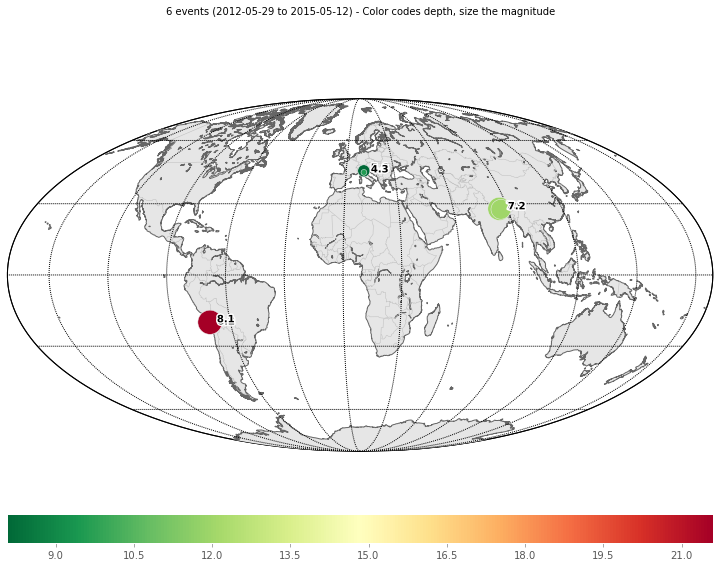

In [12]:
import glob # provides iterator to loop over files

cat = obspy.core.event.Catalog()

for filename in glob.iglob(os.path.join(quakeml_folder, '*.xml')):
     cat += obspy.readEvents(filename)
        
print(cat)
print(instaseis.Source.parse(cat.events[0]))
cat.plot();

**Alternatively** load QuakeML or CMTSOLUTION files directly using `instaseis.Source.parse()` and store the sources in a list:

In [13]:
sources = []

for filename in glob.iglob(os.path.join(quakeml_folder, '*.xml')):
    sources.append(instaseis.Source.parse(filename))
    
print(sources[0])

for filename in glob.iglob(os.path.join(cmtsolutions_folder, '*')):
    sources.append(instaseis.Source.parse(filename))

print(sources[0])

Instaseis Source:
	origin time      : 2015-04-25T06:11:58.400000Z
	Longitude        :   85.4 deg
	Latitude         :   27.8 deg
	Depth            : 1.2e+01 km
	Moment Magnitude :   7.93
	Scalar Moment    :   7.76e+20 Nm
	Mrr              :   1.73e+20 Nm
	Mtt              :  -1.79e+20 Nm
	Mpp              :   5.60e+18 Nm
	Mrt              :   7.52e+20 Nm
	Mrp              :  -5.87e+19 Nm
	Mtp              :   4.54e+19 Nm

Instaseis Source:
	origin time      : 2015-04-25T06:11:58.400000Z
	Longitude        :   85.4 deg
	Latitude         :   27.8 deg
	Depth            : 1.2e+01 km
	Moment Magnitude :   7.93
	Scalar Moment    :   7.76e+20 Nm
	Mrr              :   1.73e+20 Nm
	Mtt              :  -1.79e+20 Nm
	Mpp              :   5.60e+18 Nm
	Mrt              :   7.52e+20 Nm
	Mrp              :  -5.87e+19 Nm
	Mtp              :   4.54e+19 Nm



### 3. Extract Seismograms and Save to File

For the first solution using a ObsPy event catalog:

In [14]:
dt = 1.0

for event in cat:
    src = instaseis.Source.parse(event)
    srcname = '%s_Mw_%3.1f' % (src.origin_time.date, src.moment_magnitude)
    for rec in receivers:
        # create a usefull filename
        recname = '%s_%s' % (rec.network, rec.station)
        filename = '%s_%s' % (recname, srcname)
        filename = filename.replace('.', '_')
        
        # extract seismograms using instaseis
        st = db.get_seismograms(source=src, receiver=rec, dt=dt)
        
        # write to miniseed files in the data_out folder. Write as MiniSEED due to multi
        # component support.
        st.write(os.path.join('data_out', filename + '.mseed'), format='mseed')

For the second solution use a list of sources:

In [15]:
dt = 1.0

for src in sources:
    srcname = '%s_Mw_%3.1f' % (src.origin_time.date, src.moment_magnitude)
    for rec in receivers:
        # create a usefull filename
        recname = '%s_%s' % (rec.network, rec.station)
        filename = '%s_%s' % (recname, srcname)
        filename = filename.replace('.', '_')
        
        # extract seismograms using instaseis
        st = db.get_seismograms(source=src, receiver=rec, dt=dt)
        
        # write to miniseed files in the data_out folder. Write as MiniSEED due to multi
        # component support.
        st.write(os.path.join('data_out', filename + '.mseed'), format='mseed')

## Advanced Exercise 1: Plot Record Section

Use `Instaseis` to calculate a record section of your choice.

![image](./instaseis_images/record_section.png)

#### Notes

1. ObsPy Trace objects provide a function `times()` to conveniently get the time axis for plotting and the `normalize()` function to normalize seismograms to a common amplitude.
2. Use high pass filtering and deep sources if you want to enhance body waves
3. `np.linspace()` can help to generate equidistant stations
4. `obspy.taup.TauPyModel` can be used to compare with ray theoretical arrivals

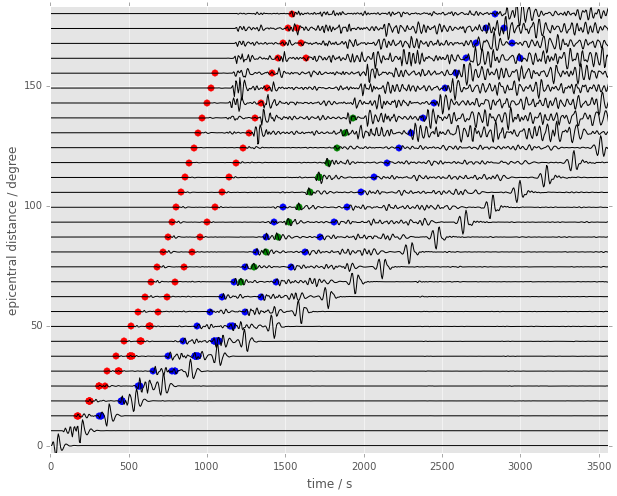

In [16]:
from obspy.taup import TauPyModel
from collections import defaultdict

m = TauPyModel(model="ak135")

# some paramters
depth_in_km = 150.
mindist = 0.
maxdist = 180.
numrec = 30
fmin = 0.02
fmax = 0.1
component = "Z"
phases = ["P", "PP", "Pdiff", "S", "SS", "PS"]
colors = ["r", "r", "r", "b", "b", "g"]

# define instaseis source
src = instaseis.Source.from_strike_dip_rake(
    latitude=0., longitude=0.,
    depth_in_m=depth_in_km * 1e3,
    M0=1e+21, strike=32., dip=62., rake=90.)

# storage for traveltimes
distances = defaultdict(list)
ttimes = defaultdict(list)

# loop over distances
for dist in np.linspace(mindist, maxdist, numrec):
    # define receiver
    rec = instaseis.Receiver(latitude=0, longitude=dist)

    # generate seismogram, filter and plot
    tr = db.get_seismograms(source=src, receiver=rec, components=[component])[0]
    tr.filter('highpass', freq=fmin)
    tr.filter('lowpass', freq=fmax)
    tr.normalize()
    plt.plot(tr.times(), tr.data * 5 + dist, color="black")
    
    # get traveltimes
    arrivals = m.get_travel_times(distance_in_degree=dist,
                                  source_depth_in_km=depth_in_km,
                                  phase_list=phases)
    for arr in arrivals:
        distances[arr.name].append(dist)
        ttimes[arr.name].append(arr.time)

# plot traveltimes
for color, phase in zip(colors, phases):
    plt.scatter(ttimes[phase], distances[phase], s=40, color=color)

plt.xlim(tr.times()[0], tr.times()[-1])
plt.ylim(mindist - 3, maxdist + 3)
plt.xlabel('time / s')
plt.ylabel('epicentral distance / degree')
plt.show()

### Advanced Exercise 2: Finite Source Effects

For earthquakes with Magnitude up to about 5 recorded at teleseismic distances, approximating the fault by a point source is a reasonable approach. However, for larger earthquakes with longer rupture duration this approximation is not valid anymore. In this exercise, you will compare the point source approximation with finite source solutions to understand its limitations.

For three of the earthquakes we use in this tutorial, USGS provides finite fault solutions: 
the recent event in [Nepal](http://earthquake.usgs.gov/earthquakes/eventpage/us20002926#scientific_finitefault),
the largest [aftershock](http://earthquake.usgs.gov/earthquakes/eventpage/us20002ejl#scientific_finitefault)
and the one in [Chile](http://earthquake.usgs.gov/earthquakes/eventpage/usc000nzvd#scientific_finitefault). This is the fault solution and slip as a function of time for the Nepal M7.9 event:

<p style="float: left; font-size: 9pt; text-align: center; width: 49%; margin-right: 1%; margin-bottom: 0.5em;"><img src="instaseis_images/finite_source_fault.png" style="width: 100%">Fault representation (image: USGS)</p><p style="float: right; font-size: 9pt; text-align: center; width: 49%; margin-right: 1%; margin-bottom: 0.5em;"><img src="instaseis_images/finite_source_stf.png" style="width: 100%">Source Time Function (image: USGS)</p><p style="clear: both;">

In Instaseis, a finite fault is represented as set of point sources, where each point source represents one of the fault patches with individual source time function. This functionality is provided by the `instaseis.FiniteSource` object [(see Documentation)](http://instaseis.net/source.html#instaseis.source.FiniteSource). It can be initialized in two ways: from a list of point sources, or more conveniently by reading \*.param files provided by USGS or standard rupture format (\*.srf) files (these can also be used in the GUI).

In [17]:
finite_source = instaseis.FiniteSource.from_usgs_param_file(
    os.path.join(finite_source_folder,
                 "FINITE_SOURCE_2015_05_12__Mw_7_2_Nepal.param"))
print(finite_source)

Instaseis Finite Source:
	Moment Magnitude     : 7.34
	scalar Moment        :   1.04e+20 Nm
	#point sources       : 525
	rupture duration     :   35.8 s
	time shift           :    0.0 s
	min depth            : 8695.7 m
	max depth            : 20897.6 m
	hypocenter depth     : 20897.6 m
	min latitude         :   27.2 deg
	max latitude         :   28.4 deg
	hypocenter latitude  :   27.8 deg
	min longitude        :   85.4 deg
	max longitude        :   86.9 deg
	hypocenter longitude :   86.2 deg



A point source can be computed as a sum of all point sources weighted by their moment:

In [18]:
finite_source.compute_centroid()
print(finite_source.CMT)

Instaseis Source:
	origin time      : 1970-01-01T00:00:00.000000Z
	Longitude        :   86.2 deg
	Latitude         :   27.8 deg
	Depth            : 1.5e+01 km
	Moment Magnitude :   7.33
	Scalar Moment    :   9.76e+19 Nm
	Mrr              :   2.63e+19 Nm
	Mtt              :  -2.46e+19 Nm
	Mpp              :  -1.70e+18 Nm
	Mrt              :   9.33e+19 Nm
	Mrp              :  -8.13e+18 Nm
	Mtp              :   9.86e+18 Nm



The hypo- and epicenter can be found as the fault patch that ruptures first:

In [19]:
finite_source.find_hypocenter()
print('hypocenter latitude:', finite_source.hypocenter_latitude,
      'longitude:', finite_source.hypocenter_longitude,
      'depth:', finite_source.hypocenter_depth_in_m / 1e3)

hypocenter latitude: 27.823 longitude: 86.1627 depth: 14.7966


**Task:** Compare the seismograms for three different representations of the source: 

* A point source with simple gaussian source time function (using CMTSOLUTION or quakeml files),
* the CMT solution using the more complex source time function provided by `finite_source.CMT`
* the full finite source solution using the `FiniteSource` object and `db.get_seismograms_finite_source()`

**Note:** First, you have to adapt the sampling of the source time functions in the finite source to the database, which works like this:

In [20]:
# reloading finite source here to be sure to have a clean source time function
finite_source = instaseis.FiniteSource.from_usgs_param_file(
    os.path.join(finite_source_folder,
                 "FINITE_SOURCE_2015_04_25__Mw_7_9_Nepal.param"))

# prepare the source time functions to be at the same sampling as the database
# first use enough samples such that the lowpassed stf will still be correctly represented
nsamp = int(db.info.period / finite_source[0].dt) * 50
finite_source.resample_sliprate(dt=finite_source[0].dt, nsamp=nsamp)
# lowpass to avoid aliasing
finite_source.lp_sliprate(freq=1.0/db.info.period)
# finally resample to the sampling as the database
finite_source.resample_sliprate(dt=db.info.dt, nsamp=db.info.npts)

finite_source.compute_centroid()

**Solution**

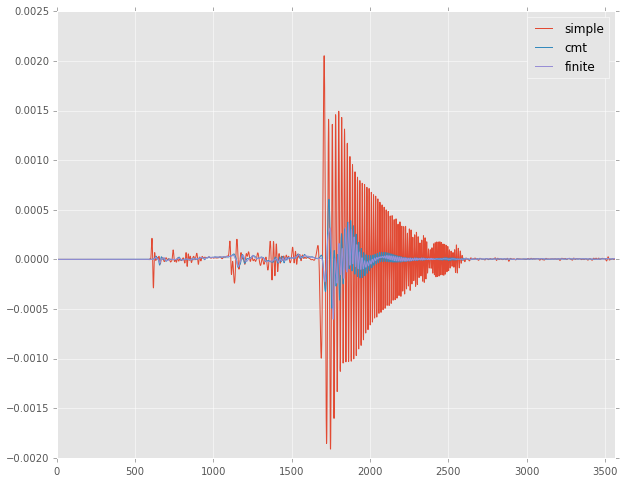

In [21]:
simple_source = instaseis.Source.parse(
    os.path.join(quakeml_folder, "GCMT_2015_04_25__Mw_7_9.xml"))

# compute seismogram with CMT solution and no simple source time function (gaussian):
tr_simple = db.get_seismograms(
    simple_source, receivers[0], components=('Z'), dt=1.)[0]

# compute seismogram with CMT solution and source time function computed as the 
# sum of all source time functions in the finite source (reconvolve_stf=True):
tr_cmt = db.get_seismograms(
    finite_source.CMT, receivers[0], components=('Z'), dt=1., reconvolve_stf=True)[0]

# compute seismogram for finite source
tr_finite = db.get_seismograms_finite_source(
    finite_source, receivers[0], components=('Z'), dt=1.)[0]

plt.plot(tr_simple.times(), tr_simple.data, label='simple')
plt.plot(tr_cmt.times(), tr_cmt.data, label='cmt')
plt.plot(tr_finite.times(), tr_finite.data, label='finite')
 
plt.legend()
plt.xlim(0, tr.times()[-1])

plt.show()

### Advanced Exercise 3: Spectra of Earthquake Source vs Meteorite Impact

The Mars [Insight Mission](http://insight.jpl.nasa.gov/home.cfm), scheduled to launch on March 4th 2016 and send the first scientific data towards the end of the same year will place a single very broad band seismic station on Mars.

<img style="width:60%" src="instaseis_images/insight.jpeg"></img>

Your task is, to discriminate between marsquakes and meteorite impacts based on the spectral properties of the body waves: while displacement seismograms of body waves are expected to have a flat spectrum below a cutoff frequency depending on the magnitude for quakes, for impacts the spectrum is linear in the frequency. This behaviour is depicted in green here (modified from Aki & Richards, 2002): 

<img style="width:50%" src="instaseis_images/spectra.png"></img>

The high frequency dependy (red) is a consequence of the finite source size and is not appropriately modeled using a point source approximation in Instaseis. Also, we only resolve periods longer than 20s in the TIDES database, so we will ignore this in the following.

**Task:** First verify this behaviour using the [instaseis.ForceSource](http://instaseis.net/source.html#forcesource) to model imacts and then write a routine that automatically determines the event type.

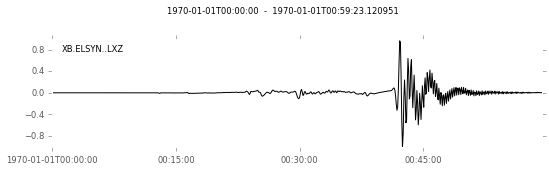

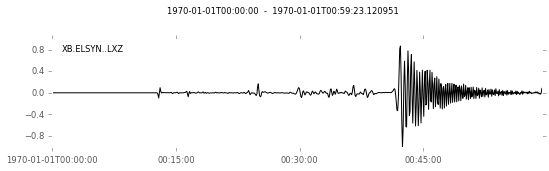

In [22]:
rec = instaseis.Receiver(latitude=4.5, longitude=136.,
                         network="XB", station="ELSYN")

src_lon = 45.
src_lat = 12.

quake = instaseis.Source.from_strike_dip_rake(
    latitude=src_lat, longitude=src_lon, depth_in_m=0.0,
    M0=1e+17, strike=32., dip=62., rake=90.)

impact = instaseis.ForceSource(
    latitude=src_lat, longitude=src_lon, depth_in_m=0.0, f_r=1e15)

tr_quake = db.get_seismograms(
    source=quake, receiver=rec, components=('Z',))[0].normalize()
tr_impact = db.get_seismograms(
    source=impact, receiver=rec, components=('Z',))[0].normalize()
tr_quake.plot()
tr_impact.plot()

Slice to the body wave time window, plot to make sure surface waves have not yet arrived. Taper to prepare for the fft.

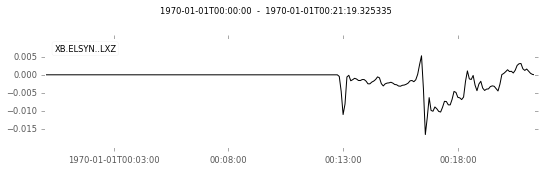

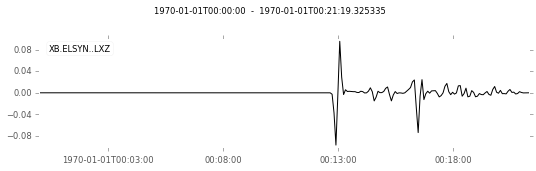

In [23]:
from obspy.taup import TauPyModel
from obspy.core.util.geodetics import locations2degrees

m = TauPyModel(model="ak135")

# window length as first arrival time + 500 seconds
dist = locations2degrees(src_lat, src_lon, rec.latitude, rec.longitude)
first_arrival = m.get_travel_times(
    distance_in_degree=dist,
    source_depth_in_km=0, phase_list=["P", "Pdiff"])[0].time

wlen = first_arrival + 500.

tr_quake_sl = tr_quake.slice(endtime=tr_quake.stats.starttime + wlen)
tr_quake_sl.taper(max_percentage=0.05)

tr_impact_sl = tr_impact.slice(endtime=tr_impact.stats.starttime + wlen)
tr_impact_sl.taper(max_percentage=0.05)

tr_quake_sl.plot()
tr_impact_sl.plot()

Compute spectra to check frequency dependence of the two event types.

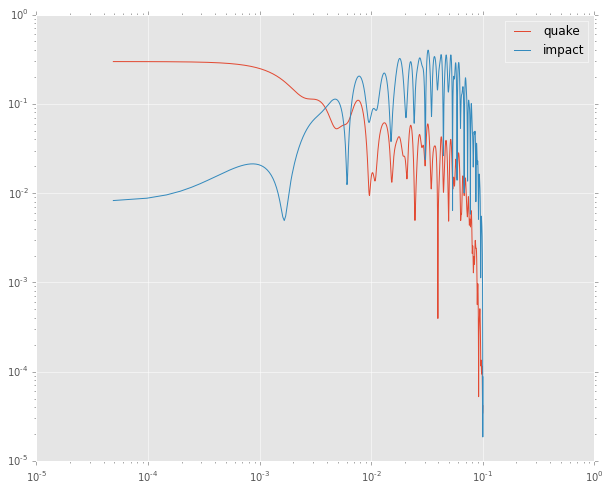

In [24]:
nfft = 2 ** 12
freqs = np.fft.rfftfreq(nfft) / db.info.dt

spec_quake = np.abs(np.fft.rfft(tr_quake_sl.data, n=nfft))
spec_impact = np.abs(np.fft.rfft(tr_impact_sl.data, n=nfft))

plt.loglog(freqs, spec_quake, label='quake')
plt.loglog(freqs, spec_impact, label='impact')
plt.legend()

plt.show()

Now put it all together to make an automated algorithm:

quake detected as quake
impact detected as impact


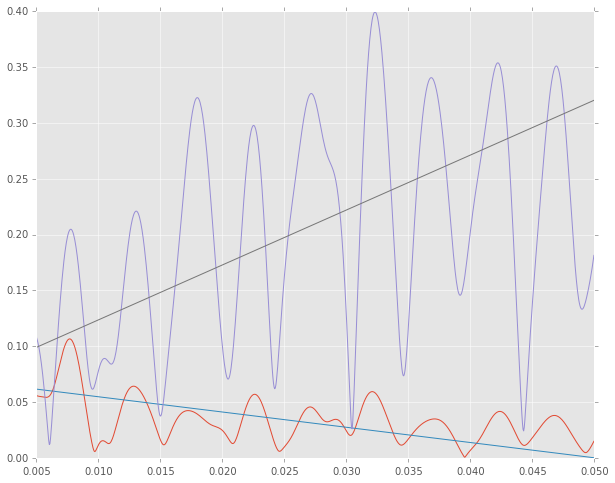

In [25]:
from scipy.optimize import curve_fit

# function to be fitted to detect linear dependence on frequency
def fitFunc(f, a, b):
    return a * f + b

def quake_or_impact(func, tr, threshold=0., fmin = 0.005,
                    fmax = 0.05, nfft = 2**12, wlen=2500.):
    
    # slice to body wave time window
    tr_sl = tr.slice(endtime=tr.stats.starttime + wlen)
    tr_sl.taper(max_percentage=0.05)
    
    # compute spectrogram
    freqs = np.fft.rfftfreq(nfft) / tr_sl.stats.delta
    spec = np.abs(np.fft.rfft(tr_sl.data, n=nfft))
    
    # slice to relevant frequency range
    freqs_sl = freqs[np.logical_and(freqs > fmin, freqs < fmax)]
    spec_sl = spec[np.logical_and(freqs > fmin, freqs < fmax)]

    # fit a linear function
    fitParams, fitCovariances = curve_fit(func, freqs_sl,
                                          spec_sl, sigma=freqs_sl)
    if fitParams[0] > threshold:
        event_type = 'impact'
    else:
        event_type = 'quake'
        
    plt.plot(freqs_sl, spec_sl)
    plt.plot(freqs_sl, fitFunc(freqs_sl, fitParams[0], fitParams[1]))

    return event_type


event_type_quake =  quake_or_impact(fitFunc, tr_quake_sl, wlen=wlen)
event_type_impact =  quake_or_impact(fitFunc, tr_impact_sl, wlen=wlen)

print('quake detected as %s' % event_type_quake)
print('impact detected as %s' % event_type_impact)